<a href="https://colab.research.google.com/github/ginomempin/machine-learning-tutorials/blob/master/src/ConvolutionalNeuralNetworks-CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OVERVIEW

This notebook demonstrates the creation, training, and testing of a **Convolutional Neural Network**.  
The network will classify objects from the [CIFAR 10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

### Reference

[ginomempin / machine-learning-tutorials / docs / ConvolutionalNeuralNetworks.md](https://github.com/ginomempin/machine-learning-tutorials/blob/master/docs/ConvolutionalNeuralNetworks.md)

### Note

This notebook requires the use of GPU (or not if you want slow/long training times).  

When running in Google Colab:
1. Select "Runtime" from the menu
1. Select "GPU" as the hardware accelerator type.

In [1]:
!pip3 install torch torchvision

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn 
from torchvision import datasets    # Contains the CIFAR 10 image dataset
from torchvision import transforms  # Contains common image pre-processing functions

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Setup the Training Set

## Define the Image Transformation

In [0]:
transform_training = transforms.Compose([
    # No effect on CIFAR 10 images, but useful for
    # passing in test images of random sizes.
    transforms.Resize((32,  32)),

    # Here we use Data Augmentation.
    #
    # It is a technique for expanding the training data by applying different
    # augmentations to the images, such as rotation, changing colors, zooming
    # in and out, translations, etc. This reduces overfitting, as it prevents 
    # the model from memorizing specific features of an object as it "sees" it 
    # in an image, but instead generalizes it for different appearances of the
    # same feature.
    #
    # For example, a STOP sign. The model should be able to know it's a STOP
    # sign, whether the sign is upright, rotated 90 degrees, black and white,
    # slightly skewed, shifted to the right.
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),

    # Convert from Numpy array 0-255 to PyTorch Tensor 0-1
    transforms.ToTensor(),  

    # For each tensor, normalize the values of image size,
    # channel height and channel width. The 1st parameter
    # is the mean and the 2nd parameter is the standard 
    # deviation. Make sure to specify only 1 channel since
    # the CIFAR 10 dataset provides grayscale images.
    #
    # We choose 0.5 because we want to normalize the Tensor
    # values from [0, 1] to be [-1, 1].
    #   Ex. If value is 0 (minimum Tensor value)
    #           (0 - 0.5) / 0.5 = -1
    #   Ex. If value is 1 (maximum Tensor value)
    #           (1 - 0.5) / 0.5 = +1
    #
    # Ultimately, we want to normalize to reduce skewness
    # and distorted data values.    
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## Define the Dataset

In [5]:
training_dataset = datasets.CIFAR10(
    root="./data",                  # Where the CIFAR 10 dataset will be stored
    train=True,                     # Create a Training Set
    download=True,                  # Downloads from internet and put in `root` directory
    transform=transform_training    # Image manipulations that will be applied to the images 
)
training_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               RandomAffine(degrees=(0, 0), scale=(0.8, 1.2), shear=(-10, 10))
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [6]:
# Provides a way to load the input data into the model in batches.
# Before we pass the entire data into the network every epoch.
 # With 60k data points, this would not be an efficient strategy.
training_loader = torch.utils.data.DataLoader(
    dataset=training_dataset,
    batch_size=100,
    shuffle=True            # Prevent getting stuck into local/false minimums
                            # Make sure that each epoch uses a different batch
)
training_loader

## Plot the Dataset

In [0]:
# To plot, we need to convert the Tensor back to Numpy array.
def img_convert(tensor: torch.Tensor):
    image = tensor.cpu().clone().detach().numpy()

    # Convert from 1x32x32 shape to 32x32x1
    # The CIFAR 10 dataset are in grayscale, hence only 1 channel.
    # Then each image is 32x32.
    # print(image.shape)
    image = image.transpose(1, 2, 0)

    # De-normalize (reverse the normalization process earlier)
    # Convert it from [-1, 1] back to the original [0, 1]
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    # print(image.shape)
    return image

In [0]:
# Refer to https://www.cs.toronto.edu/~kriz/cifar.html
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
)

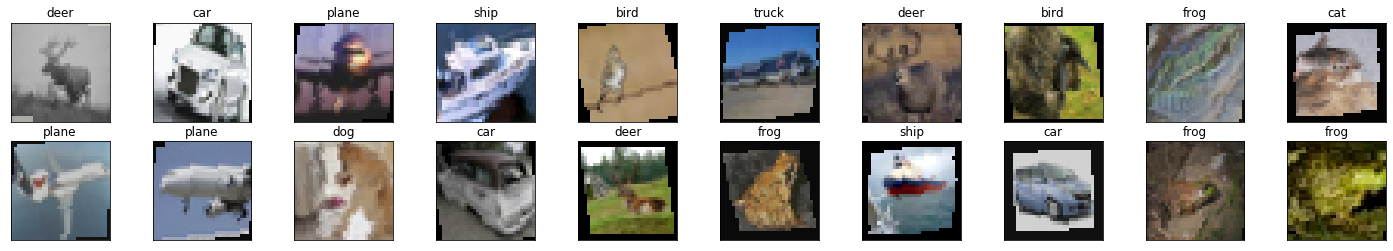

In [9]:
# Create an iterable object
# We can then use `next()` to iteratively get the next batch of data
training_dataset_iter = iter(training_loader)

images, labels = training_dataset_iter.next()
fig = plt.figure(
    figsize=(25, 4),
)

# Plot 20 CIFAR 10 images from the current batch
for idx in np.arange(20):
    # Make 2 rows of 10 columns
    # Note that idx is 0-based, but need to be 1-20
    axis = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])  

    # Show the i-th image (using the Tensor -> Numpy conversion)
    img = img_convert(images[idx])
    plt.imshow(img)

    # Show the labels for each i-th image
    axis.set_title( classes[labels[idx].item()] )

# Setup the Validation Set

## Define the Image Transformation

In [0]:
transform_validation = transforms.Compose([
    # No effect on CIFAR 10 images, but useful for
    # passing in test images of random sizes.
    transforms.Resize((32,  32)),

    # Convert from Numpy array 0-255 to PyTorch Tensor 0-1
    transforms.ToTensor(),  

    # For each tensor, normalize the values of image size,
    # channel height and channel width. The 1st parameter
    # is the mean and the 2nd parameter is the standard 
    # deviation. Make sure to specify only 1 channel since
    # the CIFAR 10 dataset provides grayscale images.
    #
    # We choose 0.5 because we want to normalize the Tensor
    # values from [0, 1] to be [-1, 1].
    #   Ex. If value is 0 (minimum Tensor value)
    #           (0 - 0.5) / 0.5 = -1
    #   Ex. If value is 1 (maximum Tensor value)
    #           (1 - 0.5) / 0.5 = +1
    #
    # Ultimately, we want to normalize to reduce skewness
    # and distorted data values.    
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [11]:
validation_dataset = datasets.CIFAR10(
    root="./data",                  # Where the CIFAR 10 dataset will be stored
    train=False,                    # Create a Validation Set
    download=True,                  # Downloads from internet and put in `root` directory
    transform=transform_validation  # Image manipulations that will be applied to the images 
)
validation_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [12]:
validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset,
    batch_size=100,
    shuffle=False
)
validation_loader

# Setup the Network

We will use the **LeNet** model as the reference for our model.

It consists of 2 convolutional-pooling layers followed by 2 FCNs.  
Using a 5x5 kernel effectively reduces the feature matrix size by 4 pixels.  
And using a max pooling function further cuts the size in half.

See [CNN-2-Architecture-24](https://github.com/ginomempin/machine-learning-tutorials/blob/master/docs/ConvolutionalNeuralNetworks.md#-and-repeat) for the dimension changes.

In [0]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            3,          # Input is RGB image (3 channels)
            16,         # Number of features to extract
            3,          # Kernel size
            1,          # Stride
            padding=1
        )
        self.conv2 = nn.Conv2d(
            16,         # Input is the features from previous conv layer
            32,         # Common architecture is to double the depth of previous layer
            3,          # Kernel size
            1,          # Stride
            padding=1
        )
        self.conv3 = nn.Conv2d(
            32,         # Input is the features from previous conv layer
            64,         # Common architecture is to double the depth of previous layer
            3,          # Kernel size
            1,          # Stride
            padding=1
        )
        self.fc1 = nn.Linear(
            4*4*64,     # Each input feature will be 5x5 and there are 64 from conv3
                        # Because of the padding, the image size to the FC will depend
                        # on the input image size (32x32), and then halved for each
                        # max pooling layer.
                        #   32x32 -> pool1 -> 16x16 -> pool2 -> 8x8 -> pool3 -> 4x4
            500         # Hidden layer
        )
        self.dropout1 = nn.Dropout(     
            0.5         # Add a dropout layer to fix the overfitting problem.
                        # This layer randomly turns on/off some nodes (specified
                        # by the rate, 0.5 in this case) making sure that all the
                        # nodes get properly trained, and the model does not only
                        # factor a specific path, which could lead to overfitting.
        )
        self.fc2 = nn.Linear(
            500,        # Hidden layer
            10          # 1 class for each possible digit
        ) 
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)  # 2x2 kernel
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)  # 2x2 kernel
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)  # 2x2 kernel
        x = x.view(-1, 4*4*64)     # 1x(4x4x64)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)            # Do not apply an activation function for non-binary classification
        return x

In [14]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

# Setup the Loss Function and Optimizer

In [0]:
# Use Cross Entropy Loss for multi-class datasets (instead of BCE for binary data)
criterion = nn.CrossEntropyLoss()  

# Use Gradient Descent to optimize the model.
# Specifically, the Adam optimizer (Adaptive Method Algorithms).
# The Adam optimizer is a combination of 2 extensions of SGD (Stochastic Gradient Descent):
#   Adagrad
#   RMSprop
# What distinguishes it from the SGD is that we had to be careful in choosing the proper
# the learning rate. Too small leads to very slow convergence towards minimum error/loss, 
# while too large can hinder the convergence. When using Adam optimization, it computes 
# the adaptive learning rates for EACH parameter. In practice, Adam is recommended as the
# default optimization algorithm.
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001    # Too high = can lead to lower accuracy
                # Too small = can lead to slower training (i.e. too many epochs to approach 100% accuracy)
)

# Training + Validation

In [16]:
epochs = 15

training_loss_history = []
training_acc_history = []

validation_loss_history = []
validation_acc_history = []

for e in range(epochs):

    # For each epoch, iterate over all the batches to be provided
    # by the training_loader, and keep track of the *total* loss
    # for all batches.
    training_running_loss = 0.0
    training_running_acc = 0.0
    validation_running_loss = 0.0
    validation_running_acc = 0.0

    print("Epoch: {}".format(e + 1))

    # Training Loop
    for images, labels in training_loader:
        inputs = images.to(device)
        labels = labels.to(device)

        # Feedforward through the model
        outputs = model.forward(inputs)

        # Get the current loss
        loss = criterion(outputs, labels)
        training_running_loss += loss.item()

        # Backpropagate the loss to update the model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Get the current maximum scored class for each output
        # Returns a tuple
        #   0: The image scores for each of the classes
        #   1: The index of the top score (i.e. which class does each image belong to?)
        _, preds = torch.max(outputs, 1)
        training_running_acc += torch.sum(preds == labels.data)    
            # Example:
            #   If preds  = [2 3 4 5 6]
            #      labels = [2 5 4 5 6]
            #   So only the 2nd prediction is incorrect.
            #   So preds == labels will be [1 0 1 1 1].
    else:  
        epoch_training_loss = training_running_loss / len(training_loader)
        epoch_training_acc  = training_running_acc.float() / len(training_loader)
        # Note that this divide by batch size only works because batch_size = 100.
        # So, dividing the loss/acc by 100 automatically gives a % value.
        # If the batch size is != 100, divide instead by the dataset size
        #   epoch_training_loss = training_running_loss / len(training_loader.dataset)
        #   epoch_training_acc  = training_running_acc.float() / len(training_loader.dataset)        

        training_loss_history.append(epoch_training_loss)
        training_acc_history.append(epoch_training_acc)

        print("Training Loss:{:.4f}, Acc:{:.4f}".format(epoch_training_loss, epoch_training_acc))

    # Validation Loop
    with torch.no_grad():
        for images, labels in validation_loader:
            inputs = images.to(device)
            labels = labels.to(device)

            outputs = model.forward(inputs) 
            
            loss = criterion(outputs, labels)
            validation_running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            validation_running_acc += torch.sum(preds == labels.data)
        else:  
            epoch_validation_loss = validation_running_loss / len(validation_loader)
            epoch_validation_acc  = validation_running_acc.float() / len(validation_loader)
            # Note that this divide by batch size only works because batch_size = 100.
            # So, dividing the loss/acc by 100 automatically gives a % value.  
            # If the batch size is != 100, divide instead by the dataset size
            #   epoch_training_loss = validation_running_loss / len(validation_loader.dataset)
            #   epoch_training_acc  = validation_running_acc.float() / len(validation_loader.dataset)                      

            validation_loss_history.append(epoch_validation_loss)
            validation_acc_history.append(epoch_validation_acc)

            print("Validation Loss:{:.4f}, Acc:{:.4f}".format(epoch_validation_loss, epoch_validation_acc))            

Epoch: 1
Training Loss:1.6923, Acc:37.9020
Validation Loss:1.4910, Acc:47.1300
Epoch: 2
Training Loss:1.3837, Acc:50.1000
Validation Loss:1.2337, Acc:55.4200
Epoch: 3
Training Loss:1.2432, Acc:55.5740
Validation Loss:1.1068, Acc:60.5100
Epoch: 4
Training Loss:1.1561, Acc:58.8620
Validation Loss:1.0332, Acc:63.4100
Epoch: 5
Training Loss:1.0922, Acc:61.3480
Validation Loss:0.9964, Acc:64.8300
Epoch: 6
Training Loss:1.0483, Acc:62.8240
Validation Loss:0.9821, Acc:66.2400
Epoch: 7
Training Loss:1.0089, Acc:64.4380
Validation Loss:0.9171, Acc:68.3900
Epoch: 8
Training Loss:0.9811, Acc:65.4360
Validation Loss:0.9211, Acc:67.9600
Epoch: 9
Training Loss:0.9521, Acc:66.4580
Validation Loss:0.8755, Acc:69.6100
Epoch: 10
Training Loss:0.9316, Acc:67.6080
Validation Loss:0.8489, Acc:70.4600
Epoch: 11
Training Loss:0.9111, Acc:67.9300
Validation Loss:0.8314, Acc:71.4400
Epoch: 12
Training Loss:0.8894, Acc:69.0080
Validation Loss:0.8212, Acc:71.8800
Epoch: 13
Training Loss:0.8859, Acc:68.9540
Valid

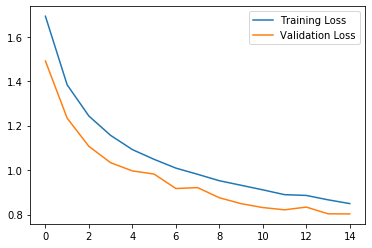

In [17]:
plt.plot(training_loss_history, label="Training Loss")
plt.plot(validation_loss_history, label="Validation Loss")
plt.legend()

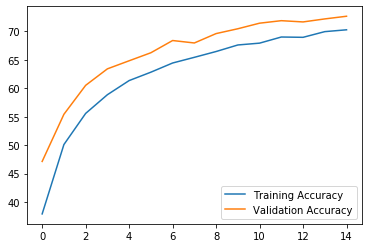

In [18]:
plt.plot(training_acc_history, label="Training Accuracy")
plt.plot(validation_acc_history, label="Validation Accuracy")
plt.legend()

# Testing

## Get a Test Image

In [0]:
test_frog_url = "https://www.aquariumofpacific.org/images/made/images/uploads/20170502_AOPfrog_pacifictree_5123_530_353_80auto_s.jpg"
test_dog_url = "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/single-minded-royalty-free-image-997141470-1558379890.jpg?crop=0.671xw:1.00xh;0.0847xw,0&resize=640:*"
test_deer_url = "https://thenypost.files.wordpress.com/2018/12/deer-program.jpg?quality=80&strip=all&w=618&h=410&crop=1"

test_url = test_deer_url

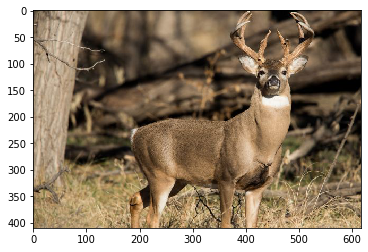

In [26]:
from PIL import Image, ImageOps
import requests

resp = requests.get(test_url, stream=True)

img_src = Image.open(resp.raw)
plt.imshow(img_src)

## Do image preprocessing

The test image must match the image format on which our model was trained on.  
* 32x32
* RGB color images

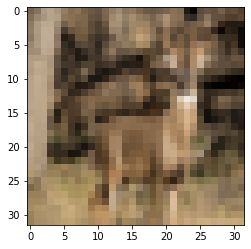

In [27]:
img_trans = transform_validation(img_src)  # apply model's expected image format
plt.imshow(img_convert(img_trans))

## Feed to Model

In [28]:
# Need 4D input to the network
# Convert 32x32 to 1x1x32x32
image_in = img_trans.to(device).unsqueeze(0)
print(image_in.size())

torch.Size([1, 3, 32, 32])


In [29]:
output = model.forward(image_in)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

deer


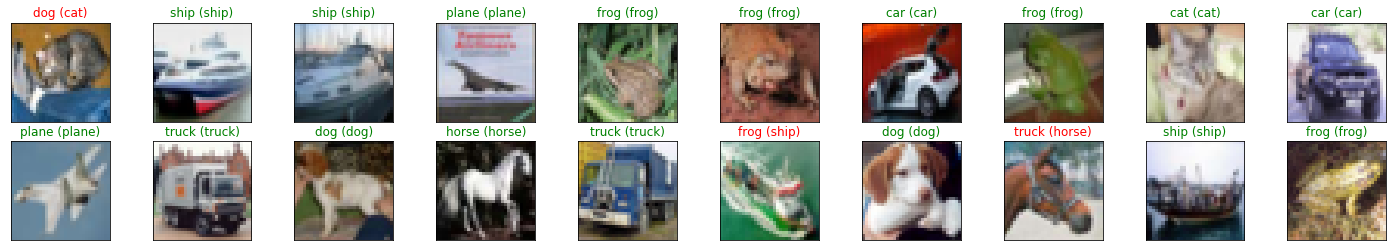

In [33]:
testdata_iter = iter(validation_loader)
images, labels = testdata_iter.next()
images = images.to(device)
labels = labels.to(device)
output = model.forward(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(img_convert(images[idx]))
  ax.set_title(
      "{} ({})".format(
        str(classes[preds[idx].item()]), 
        str(classes[labels[idx].item()])), 
      color=("green" if preds[idx]==labels[idx] else "red"))